In [1]:
# computing the differentially accessible regions for CD69 locus
# corresponds to the "ATAC differential peaks" in Figure 1B

# analyzed data was obtained from GSE155555
# Genome-wide enhancer maps link disease variants to genes and cell types
# Nasser et. al 2021

# calculate differential peaks w/ csaw workflow
# adapted from Jake Reske, MSU 2020, reskejak@msu.edu, https://github.com/reskejak

# BAMs were aligned using the ENCODE atac seq pipeline
# peaks were called using MACS2 within the same pipeline
# tweaked version of the pipeline to output intermediate files
# is located at encode_atac_copy.wdl

suppressPackageStartupMessages({library(GenomicRanges)
library(csaw)
library("edgeR")
library(data.table)
library(ggplot2)
library(dplyr)})

In [2]:
# read in replicate narrowPeaks
control1.peaks <- fread("peaks/SRR12368302_1.trim.merged.nodup.no_chrM_MT.tn5.pval0.01.300K.bfilt.narrowPeak.gz", 
                           sep="\t",header=FALSE)[,1:3]
control2.peaks <- fread("peaks/SRR12368304_1.trim.merged.nodup.no_chrM_MT.tn5.pval0.01.300K.bfilt.narrowPeak.gz", 
                           sep="\t",header=FALSE)[,1:3]
treat1.peaks <- fread("peaks/SRR12368310_1.trim.merged.nodup.no_chrM_MT.tn5.pval0.01.300K.bfilt.narrowPeak.gz", 
                           sep="\t",header=FALSE)[,1:3]
treat2.peaks <- fread("peaks/SRR12368312_1.trim.merged.nodup.no_chrM_MT.tn5.pval0.01.300K.bfilt.narrowPeak.gz", 
                           sep="\t",header=FALSE)[,1:3]
colnames(control1.peaks) <- c("chrom", "start", "end")
colnames(control2.peaks) <- c("chrom", "start", "end")
colnames(treat1.peaks) <- c("chrom", "start", "end")
colnames(treat2.peaks) <- c("chrom", "start", "end")

control1.peaks <- GRanges(control1.peaks)
control2.peaks <- GRanges(control2.peaks)
treat1.peaks <- GRanges(treat1.peaks)
treat2.peaks <- GRanges(treat2.peaks)

In [3]:
# interesect b/w bio replicates, union across conditions
treat.peaks <- GenomicRanges::intersect(treat1.peaks, treat2.peaks)
control.peaks <- GenomicRanges::intersect(control1.peaks, control2.peaks)
all.peaks <- GenomicRanges::union(treat.peaks, control.peaks)

In [4]:
if (!(dir.exists("bams"))) {
    ls()
    stop("make sure you have bams directory containing alignment. files for SRR12368302,
            SRR12368304, SRR12368310,SRR12368312")
}
# specify paired-end BAMs
pe.bams <- c("bams/SRR12368302_1.trim.merged.nodup.no_chrM_MT.bam",
             "bams/SRR12368304_1.trim.merged.nodup.no_chrM_MT.bam",
             "bams/SRR12368310_1.trim.merged.nodup.no_chrM_MT.bam",
             "bams/SRR12368312_1.trim.merged.nodup.no_chrM_MT.bam")

In [5]:
blacklist <- read.table("../../../reference_files/hg38_blacklist_ENCODE_ENCFF356LFX.bed", sep="\t")
colnames(blacklist) <- c("chrom", "start", "end")
blacklist <- GRanges(blacklist)

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,6409054,342.3,12170694,650.0,12170694,650.0
Vcells,42127510,321.5,65030376,496.2,64859318,494.9


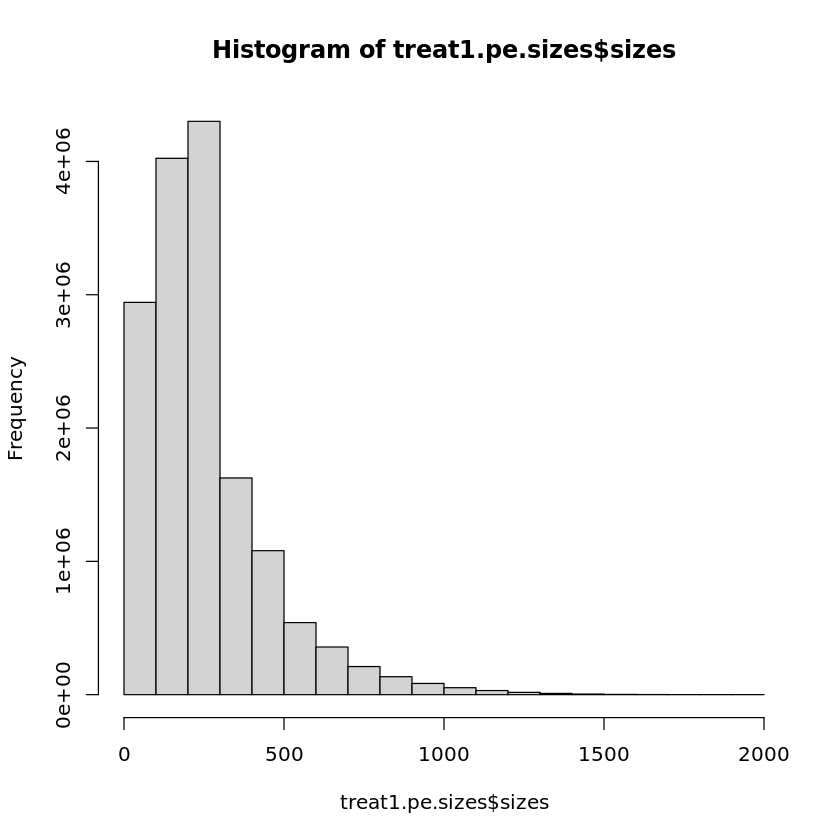

In [6]:
# define read parameters
standard.chr <- paste0("chr", c(1:22)) # only use standard chromosomes
param <- readParam(max.frag=1000, pe="both", discard=blacklist, restrict=standard.chr)

##############################
# count reads in windows specified by MACS2                                      
peak.counts <- regionCounts(pe.bams, all.peaks, param=param)

##############################
# MACS2 peaks only: filter low abundance peaks
library("edgeR")
peak.abundances <- aveLogCPM(asDGEList(peak.counts)) 
peak.counts.filt <- peak.counts[peak.abundances > -3, ] # only use peaks logCPM > -3
# few or no peaks should be removed; modify as desired

##############################

# get paired-end fragment size distribution
control1.pe.sizes <- getPESizes("bams/SRR12368302_1.trim.merged.nodup.no_chrM_MT.bam")
control2.pe.sizes <- getPESizes("bams/SRR12368304_1.trim.merged.nodup.no_chrM_MT.bam")
treat1.pe.sizes <- getPESizes("bams/SRR12368310_1.trim.merged.nodup.no_chrM_MT.bam")
treat2.pe.sizes <- getPESizes("bams/SRR12368312_1.trim.merged.nodup.no_chrM_MT.bam")
gc()
# plot
hist(treat1.pe.sizes$sizes) # repeat for all replicates and conditions

In [7]:
##############################
# count BAM reads in, e.g. 300 bp windows
counts <- windowCounts(pe.bams, width=300, param=param) # set width as desired from the fragment length distribution analyses

# filter uninteresting features (windows) by local enrichment
# local background estimator: 2kb neighborhood
neighbor <- suppressWarnings(resize(rowRanges(counts), width=2000, fix="center")) # change width parameter as desired
wider <- regionCounts(pe.bams, regions=neighbor, param=param) # count reads in neighborhoods
# filter.stat <- filterWindows(counts, wider, type="local") # the filterWindows() function is deprecated and has been replaced by filterWindowsLocal(). This is an archived step.
filter.stat <- filterWindowsLocal(counts, wider)
counts.local.filt <- counts[filter.stat$filter > log2(2),] # threshold of 2-fold increase in enrichment over 2kb neighborhood abundance; change as desired

###############################
# count BAM background bins (for TMM normalization)
binned <- windowCounts(pe.bams, bin=TRUE, width=10000, param=param)


In [8]:
peak.counts.tmm <- peak.counts.filt
peak.counts.tmm <- normFactors(binned, se.out=peak.counts.tmm)
working.windows <- peak.counts.tmm 

In [9]:
y <- asDGEList(working.windows)
colnames(y$counts) <- c("control1", "control2", "treat1", "treat2")
rownames(y$samples) <- c("control1", "control2", "treat1", "treat2")
y$samples$group <- c("control", "control", "treat", "treat")
design <- model.matrix(~0+group, data=y$samples)
colnames(design) <- c("control", "treat") # CONFIRM THAT THESE COLUMNS CORRECTLY ALIGN!!
# design
# IMPORTANT: the user should manually confirm that the design matrix is correctly labeled according to sample metadata!

In [11]:

# stabilize dispersion estimates with empirical bayes
y <- estimateDisp(y, design)
fit <- glmQLFit(y, design, robust=TRUE)

# testing for differentially-accessible windows
results <- glmQLFTest(fit, contrast=makeContrasts(treat-control, levels=design))
# head(results$table)
rowData(working.windows) <- cbind(rowData(working.windows), results$table) # combine GRanges rowdata with differential statistics
# working.windows@rowRanges
 
# merge nearby windows
# up to "tol" distance apart: 500 bp in this case; max merged window width: 5000 bp
merged.peaks <- mergeWindows(rowRanges(working.windows), tol=500L, max.width=5000L)
# summary(width(merged.peaks$region))
# should merge some peaks; change as desired

# use most significant window as statistical representation for p-value and FDR for merged windows
tab.best <- getBestTest(merged.peaks$id, results$table)
 
# concatenating all relevant statistical data for final merged windows (no redundant columns)
final.merged.peaks <- GRanges(cbind(as.data.frame(merged.peaks$region), 
                                    results$table[tab.best$rep.test, -4], tab.best[,-c(7:8)]))
 
# sort by FDR
final.merged.peaks <- final.merged.peaks[order(final.merged.peaks@elementMetadata$FDR), ]
final.merged.peaks
 
# filter by FDR threshold
FDR.thresh <- 0.05 # set as desired
final.merged.peaks.sig <- final.merged.peaks[final.merged.peaks@elementMetadata$FDR < FDR.thresh, ]
final.merged.peaks.sig # significant differentially-accessible windows

write.table(final.merged.peaks, 
           "stim_v_ctrl_csaw_DA-windows_all.txt", 
            sep="\t", quote=F, col.names=T, row.names=F)
write.table(final.merged.peaks.sig, 
            "stim_v_ctrl_csaw_DA-windows_significant.txt", 
            sep="\t", quote=F, col.names=T, row.names=F)

GRanges object with 118857 ranges and 9 metadata columns:
         seqnames              ranges strand |     logFC    logCPM         F
            <Rle>           <IRanges>  <Rle> | <numeric> <numeric> <numeric>
   60384     chr5 138469317-138470608      * |   6.25531   5.37099   735.393
   15829     chr1 227934674-227935432      * |   4.83779   4.32179   432.132
  115696    chr11   86743268-86744037      * |   5.48869   3.76163   373.782
  112138    chr11   43830868-43831314      * |   7.00383   3.46957   364.337
  111904    chr11   36149504-36150219      * |   4.84193   3.74910   341.091
     ...      ...                 ...    ... .       ...       ...       ...
  186708     chrY   24605533-24605729      * |         0   -2.6543         0
  186709     chrY   24610009-24610308      * |         0   -2.6543         0
  186710     chrY   25054458-25054557      * |         0   -2.6543         0
  186711     chrY   25059796-25060095      * |         0   -2.6543         0
  186712     chrY 

GRanges object with 34842 ranges and 9 metadata columns:
         seqnames              ranges strand |     logFC    logCPM         F
            <Rle>           <IRanges>  <Rle> | <numeric> <numeric> <numeric>
   60384     chr5 138469317-138470608      * |   6.25531   5.37099   735.393
   15829     chr1 227934674-227935432      * |   4.83779   4.32179   432.132
  115696    chr11   86743268-86744037      * |   5.48869   3.76163   373.782
  112138    chr11   43830868-43831314      * |   7.00383   3.46957   364.337
  111904    chr11   36149504-36150219      * |   4.84193   3.74910   341.091
     ...      ...                 ...    ... .       ...       ...       ...
  168891    chr19   47241125-47241318      * |  0.626727  1.907107   5.96195
    7732     chr1   94602295-94602985      * | -0.482369  3.339657   7.19420
    2443     chr1   23751215-23751589      * | -0.797961  1.200870   7.19183
  158149    chr17   74210496-74210672      * | -0.576627  2.104928   5.95778
   59879     chr5 1